Loading Data
number of zip codes: 10559
number of zip codes with solar data: 10559
number of zip codes with census data: 10559
Removing Outliers
zips after removing outliers: 7795
percent difference between continued and Carbon-efficient: 0.7703499070073463
percent difference between continued and racially-aware: 1.382462861720025
percent difference between continued and NEAT-Evaluation: 1.2761247071136625
number of panels for net zero round robin: 1050894
percentage relative to status-quo: 0.7313110647181629


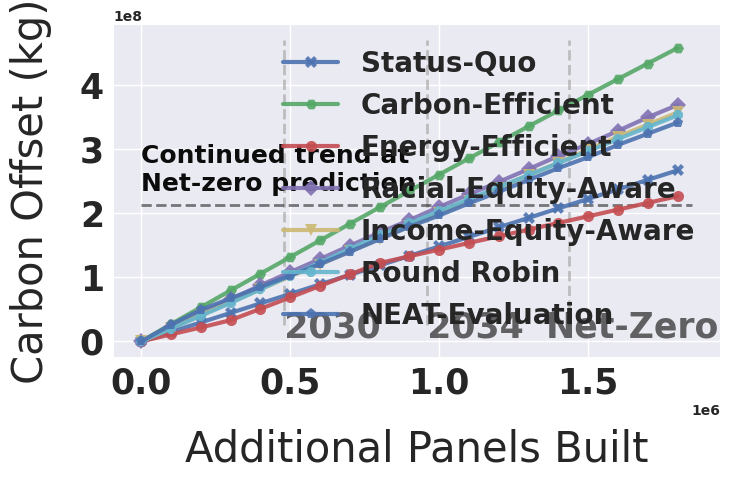

percent difference between continued and Carbon-efficient: 1.078581136584103
percent difference between continued and racially-aware: 0.8692914548285705
percent difference between continued and NEAT-Evaluation: 1.1526370290291073
number of panels for net zero round robin: 1494058
percentage relative to status-quo: 1.0397063326374392


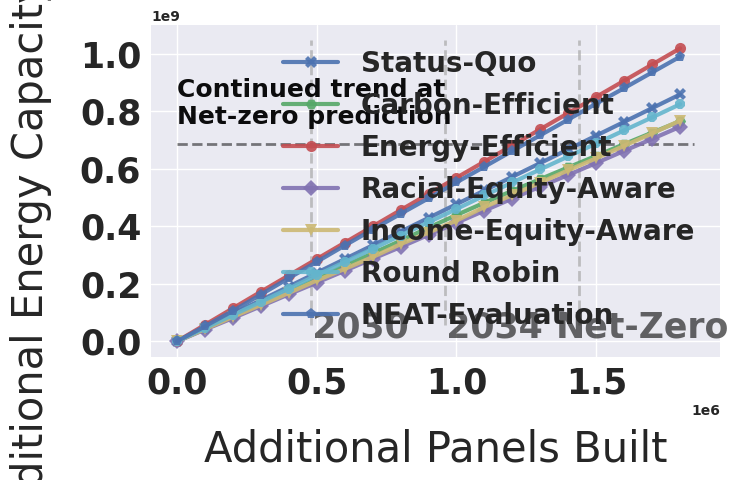

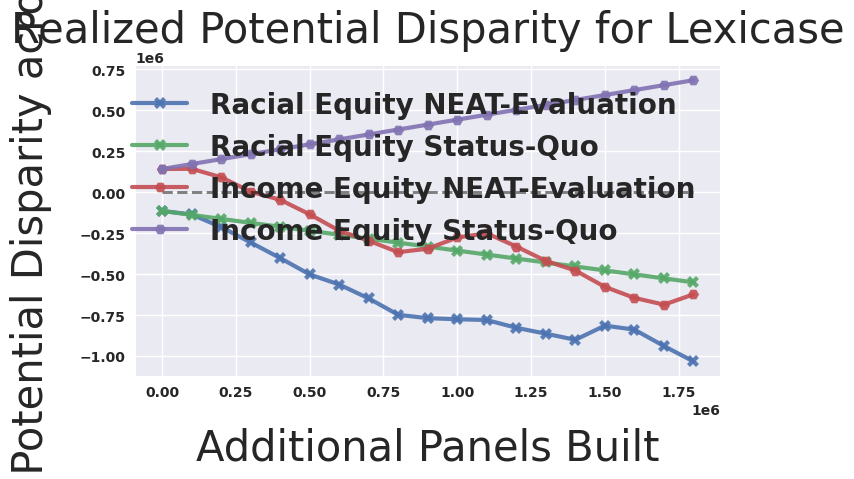

In [2]:
import math
import numpy as np
import pickle
import neat
import torch
from plot_util import *
from data_load_util import *
from projections_util import *
from Neat.evaluation_util import *
from Neat.saving_util import *

from projections import plot_projections, plot_comparison_ratio, plot_comparison

# Comparison between Status Quo and NEAT


Loading Data
number of zip codes: 10559
number of zip codes with solar data: 10559
number of zip codes with census data: 10559
Removing Outliers
zips after removing outliers: 7795


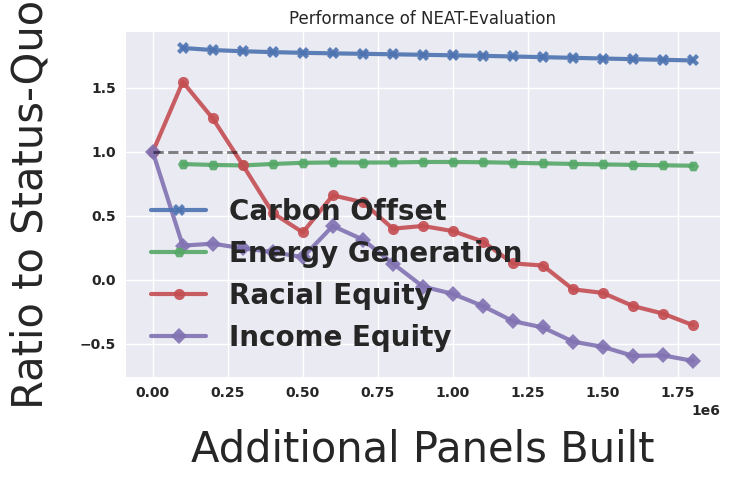

In [9]:
model_path = "Neat/models/01-01-25/NEAT_model_lexicase.pkl"
load = True #set this to False if using a new model
save_label = "lexicase" #get different projection saves

combined_df = make_dataset(remove_outliers=True)
state_df = load_state_data(combined_df, load="Clean_Data/data_by_state.csv")

max_num_added = 1850000
Energy_projections, Energy_picked = create_projections(combined_df, state_df, n=max_num_added, load=load, metric='energy_generation_per_panel', model_path=model_path, save_label=save_label)
Carbon_offset_projections, Carbon_offset_picked = create_projections(combined_df, state_df, n=max_num_added, load=load, metric='carbon_offset_kg_per_panel', model_path=model_path, save_label=save_label)
Racial_equity_projections = create_equity_projections(combined_df, Energy_picked, n=max_num_added, load=load, metric="black_prop", save_label=save_label)
Income_equity_projections = create_equity_projections(combined_df, Energy_picked, n=max_num_added, load=load, metric="Median_income", save_label=save_label)

plot_comparison_ratio([Carbon_offset_projections, Energy_projections, Racial_equity_projections, Income_equity_projections], "Status-Quo", "NEAT-Evaluation", metric_labels = ['Carbon Offset', 'Energy Generation', 'Racial Equity', 'Income Equity'], interval = 100000)


# 100k vs 1M panel projections

Loading Data
number of zip codes: 10559
number of zip codes with solar data: 10559
number of zip codes with census data: 10559
Removing Outliers
zips after removing outliers: 7795


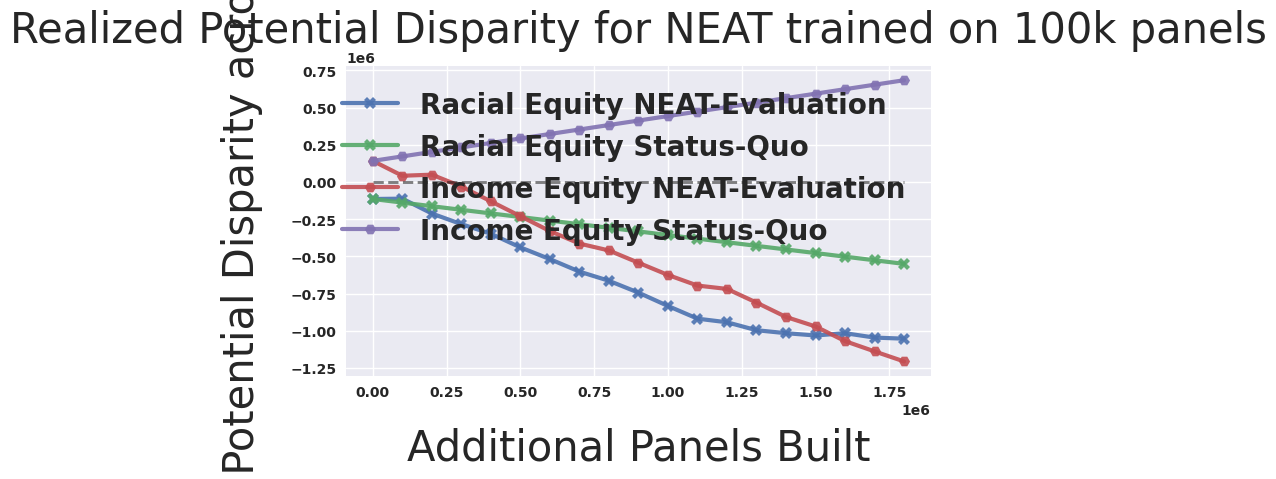

In [3]:
model_path = "Neat/models/panel experiment/NEAT_model100k.pkl"
load = True #set this to False if using a new model
save_label = "100k_panels" #get different projection saves

combined_df = make_dataset(remove_outliers=True)
state_df = load_state_data(combined_df, load="Clean_Data/data_by_state.csv")

max_num_added = 1850000
Energy_projections, Energy_picked = create_projections(combined_df, state_df, n=max_num_added, load=load, metric='energy_generation_per_panel', model_path=model_path, save_label=save_label)
Carbon_offset_projections, Carbon_offset_picked = create_projections(combined_df, state_df, n=max_num_added, load=load, metric='carbon_offset_kg_per_panel', model_path=model_path, save_label=save_label)
Racial_equity_projections = create_equity_projections(combined_df, Energy_picked, n=max_num_added, load=load, metric="black_prop", save_label=save_label)
Income_equity_projections = create_equity_projections(combined_df, Energy_picked, n=max_num_added, load=load, metric="Median_income", save_label=save_label)

plot_comparison([Racial_equity_projections, Income_equity_projections], "Status-Quo", "NEAT-Evaluation", metric_labels = ['Racial Equity', 'Income Equity'], interval = 100000, title="Realized Potential Disparity for NEAT trained on 100k panels", ylabel="Realized Potential Disparity across Median")


Loading Data
number of zip codes: 10559
number of zip codes with solar data: 10559
number of zip codes with census data: 10559
Removing Outliers
zips after removing outliers: 7795


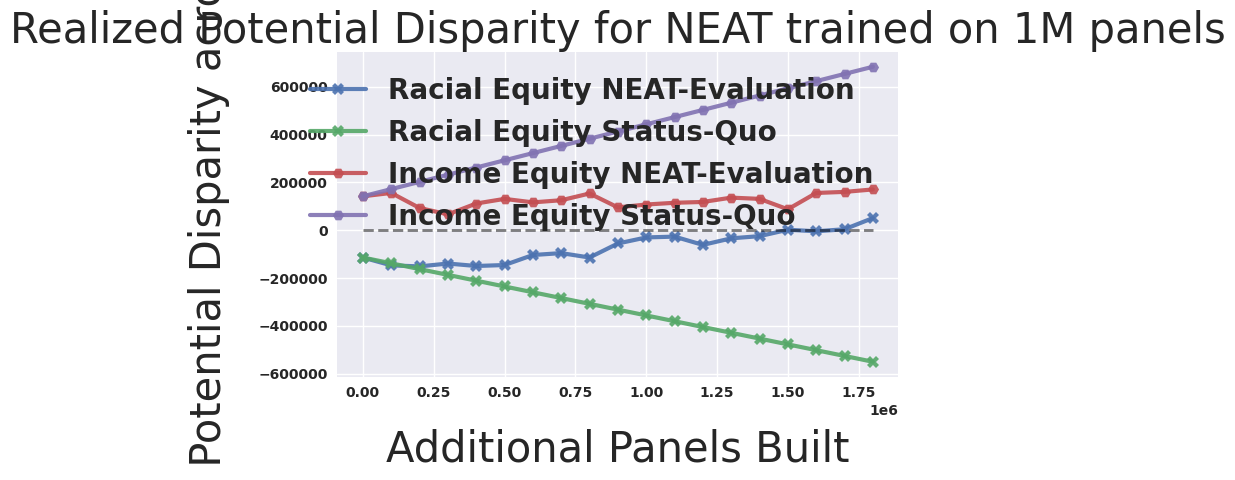

In [4]:
model_path = "Neat/models/panel experiment/NEAT_model1M.pkl"
load = True #set this to False if using a new model
save_label = "1M_panels" #get different projection saves

combined_df = make_dataset(remove_outliers=True)
state_df = load_state_data(combined_df, load="Clean_Data/data_by_state.csv")

max_num_added = 1850000
Energy_projections, Energy_picked = create_projections(combined_df, state_df, n=max_num_added, load=load, metric='energy_generation_per_panel', model_path=model_path, save_label=save_label)
Carbon_offset_projections, Carbon_offset_picked = create_projections(combined_df, state_df, n=max_num_added, load=load, metric='carbon_offset_kg_per_panel', model_path=model_path, save_label=save_label)
Racial_equity_projections = create_equity_projections(combined_df, Energy_picked, n=max_num_added, load=load, metric="black_prop", save_label=save_label)
Income_equity_projections = create_equity_projections(combined_df, Energy_picked, n=max_num_added, load=load, metric="Median_income", save_label=save_label)

plot_comparison([Racial_equity_projections, Income_equity_projections], "Status-Quo", "NEAT-Evaluation", metric_labels = ['Racial Equity', 'Income Equity'], interval = 100000, title="Realized Potential Disparity for NEAT trained on 1M panels", ylabel="Realized Potential Disparity across Median")


# Lexicase Comparison vs NEAT Benchmarks

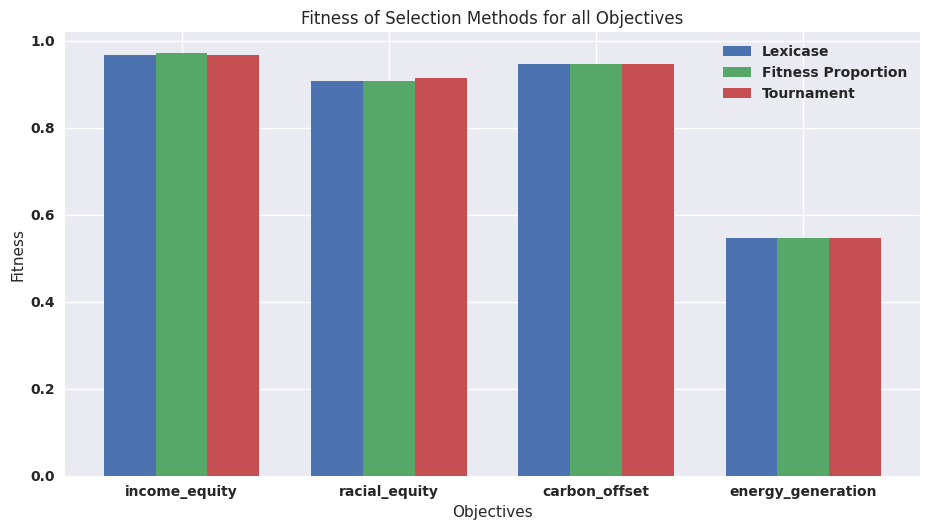

In [5]:
import matplotlib.pyplot as plt
import numpy as np


#load the things
folder = "01-01-25"#"NEAT benchmark experiment"
with open(f'NEAT/models/{folder}/lexicase_results.pkl', 'rb') as f:
    lexi_results = pickle.load(f)
with open(f'NEAT/models/{folder}/fitness_prop_results.pkl', 'rb') as f:
    fp_results = pickle.load(f)
with open(f'NEAT/models/{folder}/tournament_results.pkl', 'rb') as f:
    tourney_results = pickle.load(f)

# Data
methods = ['Lexicase', 'Fitness Proportion', 'Tournament']
objectives = ['income_equity', 'racial_equity', 'carbon_offset', 'energy_generation']

# Example results for each method across objectives
results = [
    lexi_results,
    fp_results,
    tourney_results
]

# Configuration for the bar graph
x = np.arange(len(objectives))  # X positions for the groups
width = 0.25  # Width of each bar

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each method
for i, method in enumerate(methods):
    ax.bar(x + i * width, results[i], width, label=method)

# Add labels, title, and legend
ax.set_xlabel('Objectives')
ax.set_ylabel('Fitness')
ax.set_title('Fitness of Selection Methods for all Objectives')
ax.set_xticks(x + width)
ax.set_xticklabels(objectives)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Testing


In [2]:
combined_df = make_dataset(remove_outliers=True)
state_df = load_state_data(combined_df, load="Clean_Data/data_by_state.csv")

data_manager = DataManager(combined_df, state_df)

Loading Data
number of zip codes: 10559
number of zip codes with solar data: 10559
number of zip codes with census data: 10559
Removing Outliers
zips after removing outliers: 7795


In [3]:

print(combined_df["existing_installs_count"].head())
print(state_df["existing_installs_count"].head())

0    10.253550
1    15.412134
2     2.047568
3     9.164546
4    14.746581
Name: existing_installs_count, dtype: float64
0      2.756624
1      6.055220
2    232.038324
3      3.552648
4    324.973372
Name: existing_installs_count, dtype: float64


In [10]:
#load model ex. 'Neat/models/NEAT_model.pkl'
with open('NEAT/models\\12-24-24\\NEAT_model1M.pkl', 'rb') as f:
    winner = pickle.load(f)

#load fitness data
# with open('Neat/models/fitness_data.pkl', 'rb') as f:
#     fitness_data = pickle.load(f)


#load most recent model
# winner, fitness_data = load_latest(model_name="NEAT_model_lexicase.pkl")

In [11]:
#run model to get the zip order
zip_outputs = []
for i in range(0, data_manager.num_zips):
    score = winner.activate(data_manager.network_inputs(i, train=False))
    zip_outputs.append((i, score))

zip_outputs.sort(key=lambda z: z[1], reverse=True) #sort by highest score
zip_order = [index for index, score in zip_outputs]

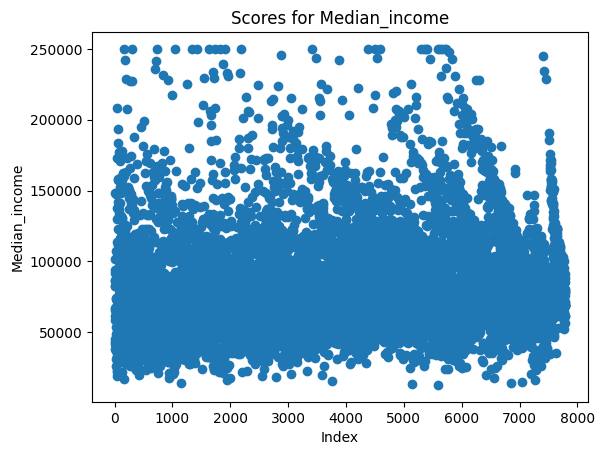

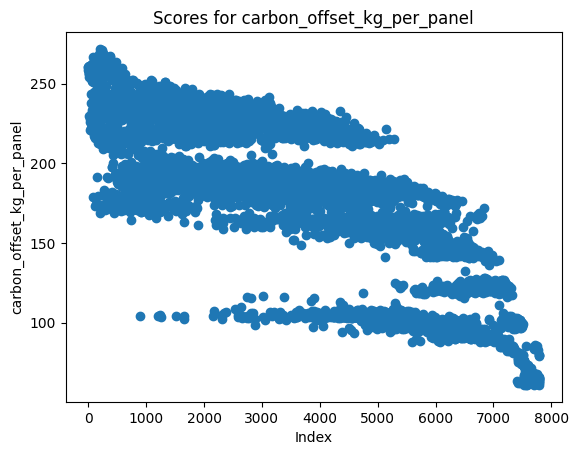

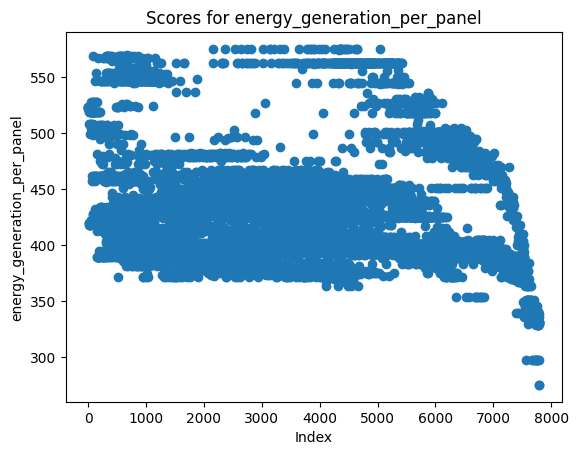

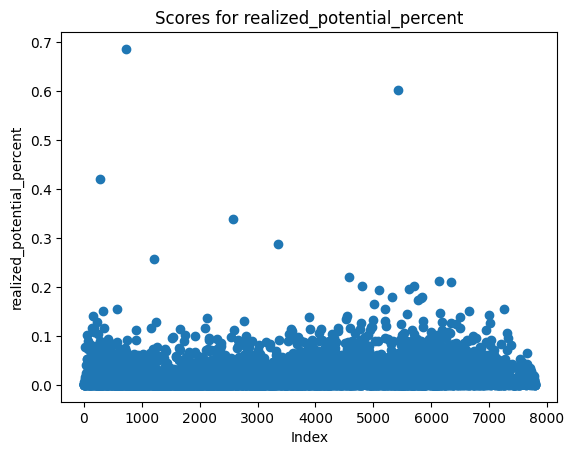

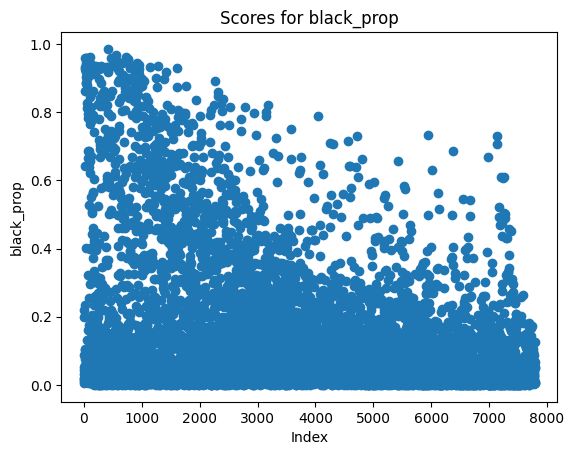

In [12]:

metrics = ['Median_income', 'carbon_offset_kg_per_panel', 'energy_generation_per_panel', 'realized_potential_percent', 'black_prop']

for m in metrics:
    arr = []
    for i in range(len(zip_order)):
        arr.append(combined_df[m][zip_order[i]])
        # arr.append()


    plt.scatter(list(range(len(arr))), arr, marker='o')
    plt.xlabel("Index")
    plt.ylabel(m)
    plt.title(f"Scores for {m}")
    plt.show()

In [13]:
# # Plot best scores per generation
# plt.scatter(list(range(len(fitness_data))), fitness_data, marker='o')
# plt.xlabel("Index")
# plt.ylabel("Score")
# plt.title("Scores for Metric")
# plt.show()

In [14]:
#add the NEAT score for each zip to the df
zip_dict = dict([(index, score[0]) for index, score in zip_outputs])
combined_df['NEAT-Evaluation'] = combined_df.index.map(zip_dict)


In [15]:
#create a heatmap for the zip scores
from plot_util import geo_plot

geo_plot(combined_df['NEAT-Evaluation'], color_scale='agsunset', title="NEAT-Evaluation", edf=combined_df, zipcodes=combined_df, colorbar_label="", size=10)


difference for 0: -114209.39391735679


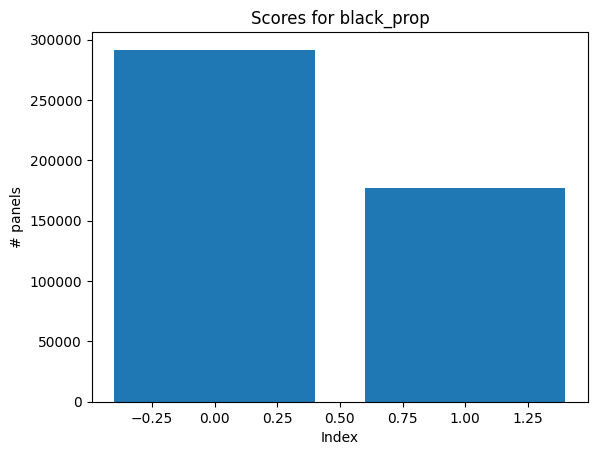

difference for 100000: -147089.3939173568


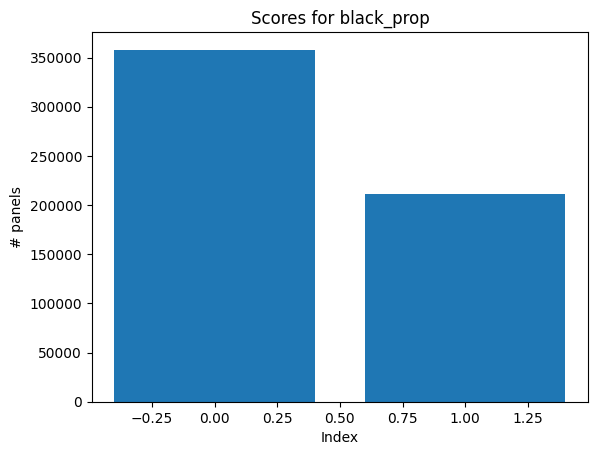

difference for 500000: -145659.3939173568


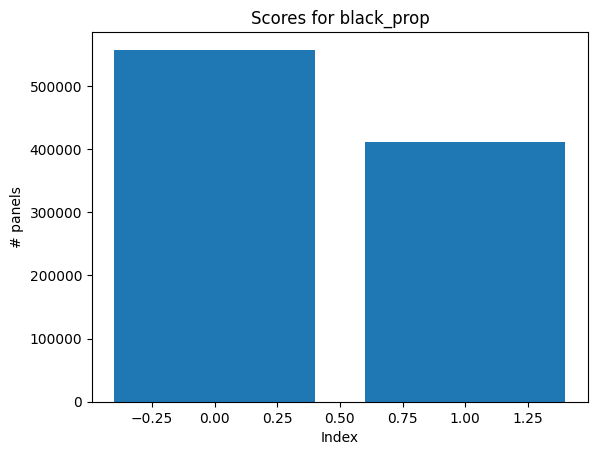

difference for 1000000: -30173.393917356734


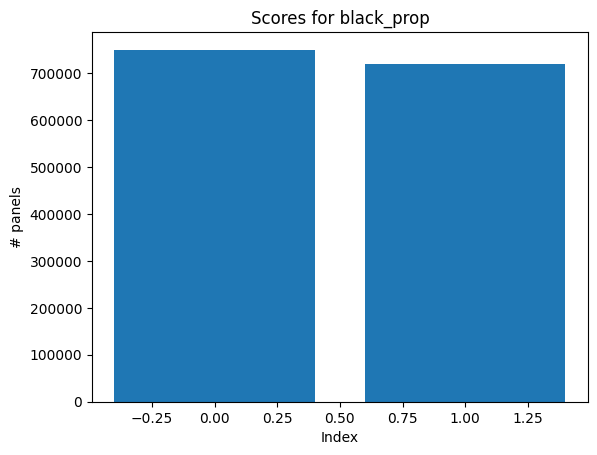

difference for 2000000: 88424.60608264338


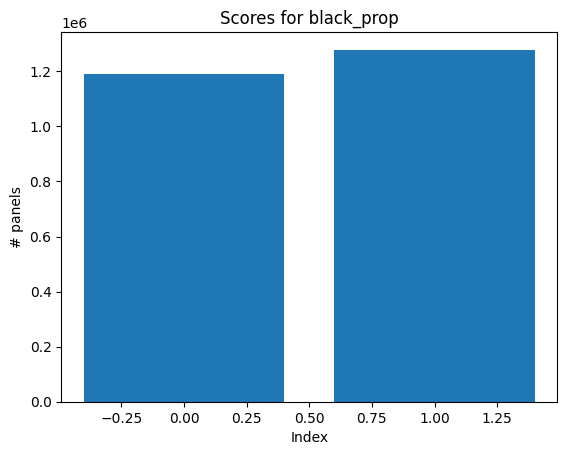

difference for 0: 141951.0075989457


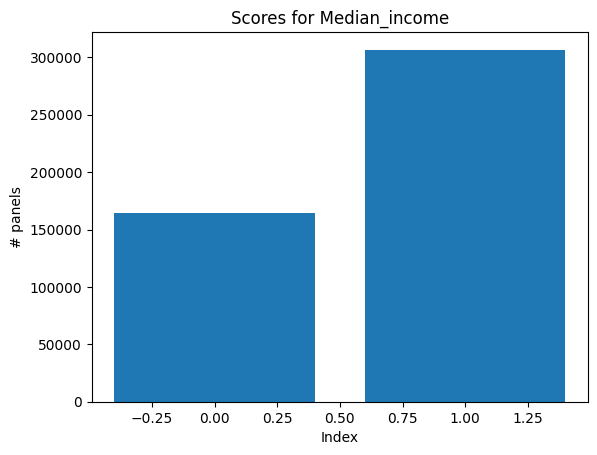

difference for 100000: 156029.0075989457


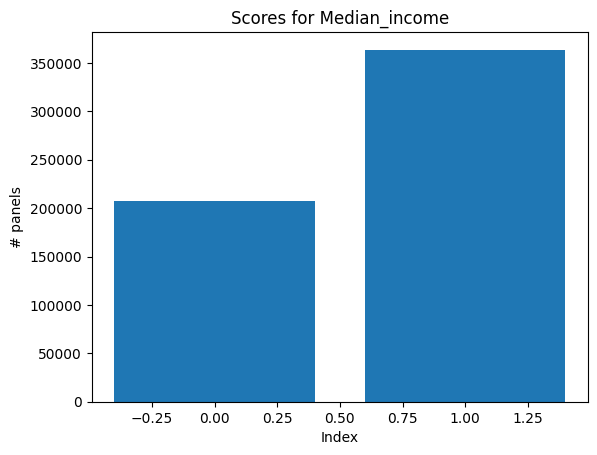

difference for 500000: 131153.00759894575


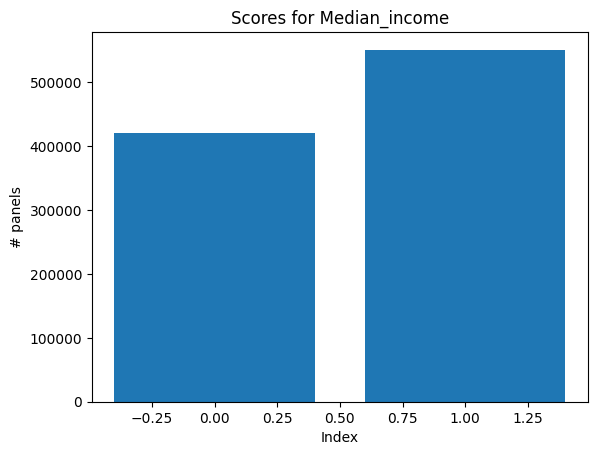

difference for 1000000: 107551.00759894575


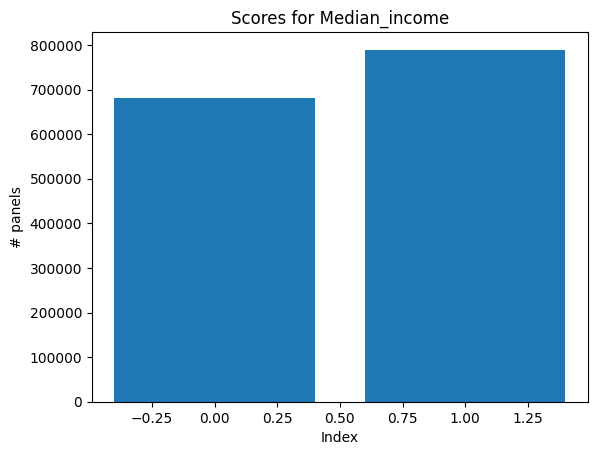

difference for 2000000: 219767.00759894564


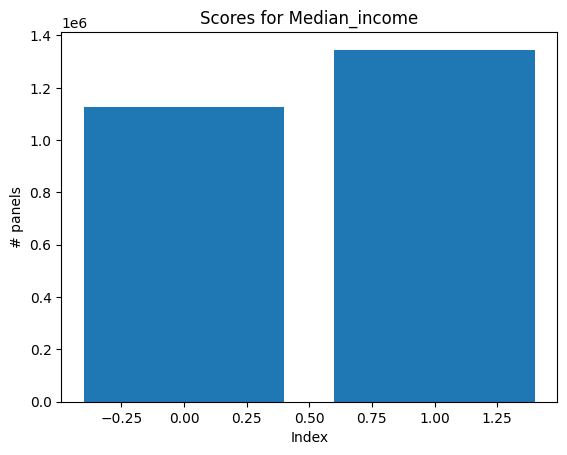

In [16]:
#plot bar buckets

metrics = ['black_prop','Median_income']
k = 2

for m in metrics:
    for panels in [0, 100000,500000, 1000000, 2000000]:
        # #alternate way
        q = np.linspace(0, 1, k+1)
        thresholds = data_manager.normalized_df[m].quantile(q).to_numpy()
        buckets, _ = data_manager.greedy_projection_bucket(zip_order, m, n=panels, record=True, thresholds=thresholds)
        print(f"difference for {panels}: {buckets[1]-buckets[0]}")
        #plot buckets
        plt.bar(list(range(k)), buckets)
        plt.xlabel("Index")
        plt.ylabel("# panels")
        plt.title(f"Scores for {m}")
        plt.show()